### Посмотрим на данные

In [4]:
import numpy as np
import torch
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from segmentation_models_pytorch.base import SegmentationHead

In [85]:
original_images_path : str = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
images_semantic_path : str = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"
        
need_dataset_size : int = 64 # сократил размер датасета, чтобы модель быстрее обучалась
num_of_classes : int = 23
train_batch_size : int = 16
valid_batch_size : int = 8
epoch_count : int = 10
early_stopping_patience : int = 3

val_rate : float = 0.25
learning_rate : float = 0.01
    
imgs_size : tuple = (512,512)

### Создадим датасет

In [86]:
class SegmentationDataset(Dataset):
    
    def __init__(self, imgs_dir, masks_dir, dataset_type='train', val_rate=val_rate, imgs_size=imgs_size):
        self.imgs_size = imgs_size
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        
        imgs_paths = os.listdir(self.imgs_dir)
        masks_paths = os.listdir(self.masks_dir)
        
        #train_size = round(len(imgs_paths) * (1-val_rate))
        
        train_size = round(need_dataset_size * (1-val_rate))
        
        if dataset_type == 'train':
            self.imgs_paths = imgs_paths[:train_size]
            self.masks_paths = masks_paths[:train_size]
            
        elif dataset_type == 'validation':
            self.imgs_paths = imgs_paths[train_size:need_dataset_size]
            self.masks_paths = masks_paths[train_size:need_dataset_size]
            
        self.imgs_paths.sort()
        self.masks_paths.sort()
        
    def __len__(self):
        return len(self.imgs_paths)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.imgs_dir, self.imgs_paths[idx]))
        mask = Image.open(os.path.join(self.masks_dir, self.masks_paths[idx])).convert('L')
        
        transform = transforms.Compose([
            transforms.Resize(self.imgs_size),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        
        img = transform(img)
        img = img.float()
        
        mask = transforms.Resize(self.imgs_size)(mask)
        mask = torch.tensor(np.array(mask))
        mask = mask.long()
        
        return img, mask

In [87]:
train_dataset = SegmentationDataset(original_images_path, images_semantic_path)
validation_dataset = SegmentationDataset(original_images_path, images_semantic_path, dataset_type='validation')

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_loader = DataLoader(validation_dataset, batch_size=valid_batch_size, shuffle=True)

### Создадим модель

In [88]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=num_of_classes)

model.segmentation_head = SegmentationHead(
                    in_channels=16,
                    out_channels=num_of_classes,
                    activation='sigmoid')

for param in model.encoder.parameters():
    param.requires_grad = False

### Обучение

In [89]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [90]:
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

In [91]:
loss_fn = CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [92]:
train_val_curve = {
    'train_loss' : [],
    'train_accuracy' : [],
    'val_loss' : [],
    'val_accuracy' : []
}

def pixelwise_accuracy(pred, mask):
    pos = torch.eq(pred,mask).int()
    return float(torch.sum(pos) / torch.numel(pos))


def training_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, total_accuracy = 0, 0
    for batch, (img_batch, mask_batch) in enumerate(dataloader, start=1):
        img_batch = img_batch.to(device) 
        mask_batch = mask_batch.to(device)
        
        output_batch = model(img_batch)
        training_loss = loss_fn(output_batch, mask_batch)
        pred = F.softmax(output_batch, dim=1).argmax(dim=1)
        accuracy = pixelwise_accuracy(pred, mask_batch)
        
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()
        
        total_loss += training_loss.item()
        total_accuracy += accuracy
        
        print(f"training loss: {(training_loss):.3f} | training accuracy : {100*(accuracy):.3f} % [{batch*train_batch_size}/{size}]")
        
    train_val_curve['train_loss'].append(total_loss/num_batches)
    train_val_curve['train_accuracy'].append(100*(total_accuracy/num_batches))
            
def validation_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    val_loss, accuracy = 0, 0
    
    with torch.no_grad():
        for img_batch, mask_batch in dataloader:
            img_batch = img_batch.to(device) 
            mask_batch = mask_batch.to(device)
            output_batch = model(img_batch)
            pred = F.softmax(output_batch, dim=1).argmax(dim=1)
            
            accuracy += pixelwise_accuracy(pred, mask_batch)
            val_loss += loss_fn(output_batch, mask_batch).item()
            
    val_loss /= num_batches
    accuracy /= num_batches
    
    train_val_curve['val_loss'].append(val_loss)
    train_val_curve['val_accuracy'].append(100*accuracy)
    
    print(f"validation loss: {(val_loss):.3f} | validation accuracy : {100*(accuracy):.3f} %")
    
    return (val_loss, accuracy)

In [93]:
valid_loss = float('inf')
valid_accuracy = 0
patience_count = 0
x_epoch = epoch_count

for epoch_num in tqdm(range(1, epoch_count+1)):
    
    print(f"Epoch : {epoch_num} / {epoch_count}")
    training_loop(train_loader, model, loss_fn, optimizer, epoch_num)
    cur_val_loss, cur_accuracy = validation_loop(valid_loader, model, loss_fn)
    
    if cur_accuracy > valid_accuracy:
        valid_accuracy = cur_accuracy
        torch.save(model, "./entire_model.pt")
    
    if cur_val_loss < valid_loss:
        valid_loss = cur_val_loss
        patience_count = 0
    else:
        patience_count += 1
    
    if patience_count == early_stopping_patience:
        x_epoch = epoch_count
        print(f"Early stopping: best validation loss = {(valid_loss):.3f}")
        break
        
print("Done!")    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1 / 10
training loss: 3.142 | training accuracy : 3.052 % [16/48]
training loss: 3.013 | training accuracy : 17.343 % [32/48]
training loss: 2.910 | training accuracy : 15.212 % [48/48]


 10%|█         | 1/10 [00:48<07:20, 48.99s/it]

validation loss: 2.772 | validation accuracy : 20.181 %
Epoch : 2 / 10
training loss: 2.789 | training accuracy : 16.640 % [16/48]
training loss: 2.743 | training accuracy : 28.136 % [32/48]
training loss: 2.739 | training accuracy : 23.784 % [48/48]


 20%|██        | 2/10 [01:37<06:30, 48.82s/it]

validation loss: 2.659 | validation accuracy : 26.891 %
Epoch : 3 / 10
training loss: 2.674 | training accuracy : 24.867 % [16/48]
training loss: 2.703 | training accuracy : 28.452 % [32/48]
training loss: 2.689 | training accuracy : 36.840 % [48/48]


 30%|███       | 3/10 [02:26<05:41, 48.83s/it]

validation loss: 2.644 | validation accuracy : 37.718 %
Epoch : 4 / 10
training loss: 2.679 | training accuracy : 35.595 % [16/48]
training loss: 2.708 | training accuracy : 33.171 % [32/48]
training loss: 2.647 | training accuracy : 34.323 % [48/48]


 40%|████      | 4/10 [03:16<04:55, 49.29s/it]

validation loss: 2.643 | validation accuracy : 37.943 %
Epoch : 5 / 10
training loss: 2.677 | training accuracy : 40.709 % [16/48]
training loss: 2.676 | training accuracy : 33.578 % [32/48]
training loss: 2.675 | training accuracy : 28.999 % [48/48]


 50%|█████     | 5/10 [04:05<04:05, 49.18s/it]

validation loss: 2.645 | validation accuracy : 37.945 %
Epoch : 6 / 10
training loss: 2.679 | training accuracy : 34.049 % [16/48]
training loss: 2.688 | training accuracy : 33.804 % [32/48]
training loss: 2.653 | training accuracy : 35.436 % [48/48]


 60%|██████    | 6/10 [04:54<03:17, 49.27s/it]

validation loss: 2.642 | validation accuracy : 37.945 %
Epoch : 7 / 10
training loss: 2.662 | training accuracy : 37.507 % [16/48]
training loss: 2.626 | training accuracy : 30.810 % [32/48]
training loss: 2.727 | training accuracy : 34.973 % [48/48]


 70%|███████   | 7/10 [05:44<02:27, 49.24s/it]

validation loss: 2.640 | validation accuracy : 37.945 %
Epoch : 8 / 10
training loss: 2.690 | training accuracy : 34.897 % [16/48]
training loss: 2.676 | training accuracy : 30.280 % [32/48]
training loss: 2.642 | training accuracy : 38.113 % [48/48]


 80%|████████  | 8/10 [06:33<01:38, 49.16s/it]

validation loss: 2.645 | validation accuracy : 37.938 %
Epoch : 9 / 10
training loss: 2.675 | training accuracy : 27.108 % [16/48]
training loss: 2.710 | training accuracy : 36.487 % [32/48]
training loss: 2.605 | training accuracy : 39.486 % [48/48]


 90%|█████████ | 9/10 [07:21<00:49, 49.04s/it]

validation loss: 2.639 | validation accuracy : 37.880 %
Epoch : 10 / 10
training loss: 2.650 | training accuracy : 39.278 % [16/48]
training loss: 2.649 | training accuracy : 29.935 % [32/48]
training loss: 2.669 | training accuracy : 34.090 % [48/48]


100%|██████████| 10/10 [08:10<00:00, 49.09s/it]

validation loss: 2.646 | validation accuracy : 37.891 %
Done!


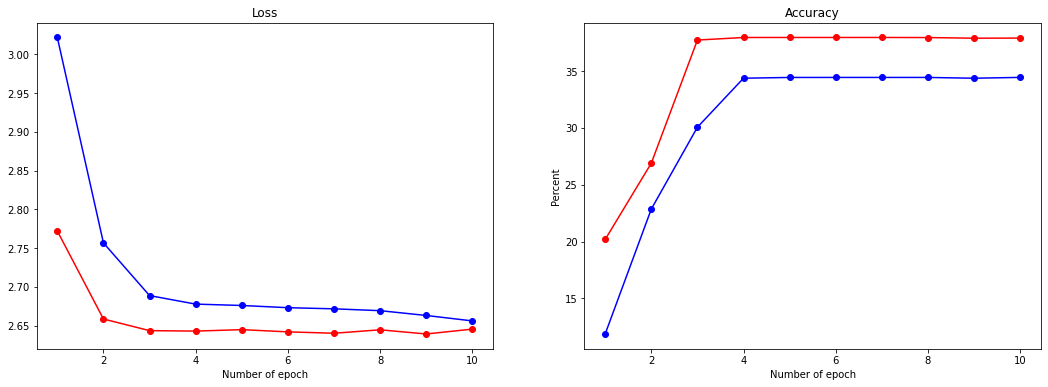

In [94]:
def draw_curve(x_epoch):
    x_epoch = range(1, x_epoch+1)
    fig = plt.figure(figsize=(18,6))
    ax0 = fig.add_subplot(121, title="Loss", xlabel='Number of epoch')
    ax1 = fig.add_subplot(122, title="Accuracy", xlabel='Number of epoch', ylabel='Percent')
    ax0.plot(x_epoch, train_val_curve['train_loss'], 'bo-', label='train')
    ax0.plot(x_epoch, train_val_curve['val_loss'], 'ro-', label='val')
    ax1.plot(x_epoch, train_val_curve['train_accuracy'], 'bo-', label='train')
    ax1.plot(x_epoch, train_val_curve['val_accuracy'], 'ro-', label='val')
    plt.show()

draw_curve(epoch_count)